## 1. Загрузка данных

#### Подключаем библиотеки и скрипты

In [289]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [290]:
import warnings
warnings.filterwarnings('ignore')

In [291]:
matplotlib.rcParams.update({'font.size': 14})

In [292]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Пути к файлам и директориям

In [293]:
TRAIN_DATASET_PATH = r'train.csv'
TEST_DATASET_PATH = r'test.csv'
SAMPLE_SUBMISSION_DATASET_PATH = r'sample_submission.csv'

#### Загрузка данных

In [294]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, encoding='utf-8')
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [295]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [296]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [297]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [298]:
# в тренировочной таблице должно быть на одну колонку (Price) больше, чем в тестовой

train_df.shape[1] - 1 == test_df.shape[1]

True

#### Приведение типов

In [299]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [300]:
# Приводим некоторые числовые категории (Id, DistrictId) в текстовый тип

train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 2. EDA

#### Целевая переменная

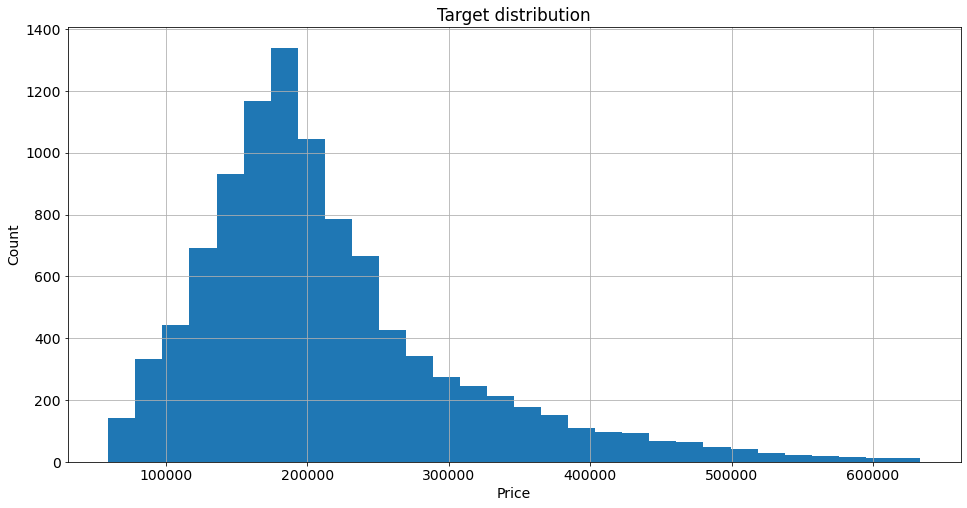

In [301]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

##### Количественные переменные

In [302]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Номинативные переменные

In [303]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [304]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
205      1
209      1
117      1
199      1
196      1
Name: DistrictId, Length: 205, dtype: int64

In [305]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [306]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [307]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

#### Обработка выбросов, пропусков, опечаток

In [308]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

#### Построение новых признаков

In [309]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

#### Отбор признаков

In [310]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [311]:
# feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
#                  'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
#                  'Helthcare_2', 'Shops_1', 'Shops_2']

feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                 'Shops_1']

# new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
#                      'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

new_feature_names = ['DistrictSize',
                     'MedPriceByFloorYear']

target_name = 'Price'

#### Разбиение на train и test

In [312]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [313]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=9)

In [314]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [315]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [316]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [317]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

## 2. Построение модели

#### Обучение

In [318]:
rf_model = RandomForestRegressor(random_state=9, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=9)

#### Оценка модели

Train R2:	0.962
Test R2:	0.734


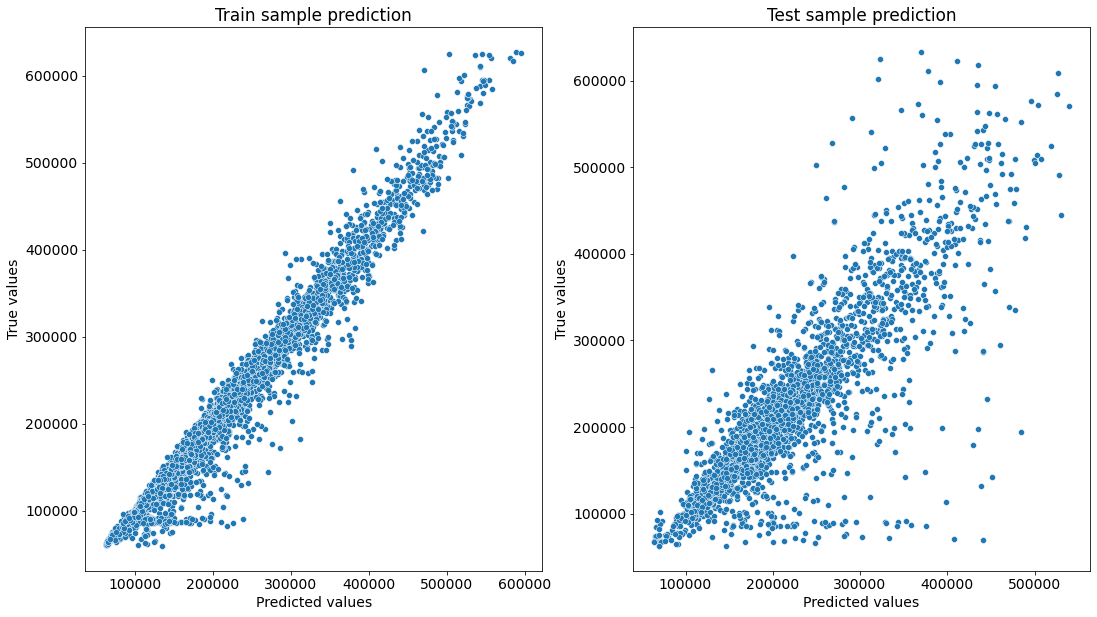

In [319]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация

In [320]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=9))
cv_score

array([0.74282685, 0.69586137, 0.73319967])

In [321]:
cv_score.mean()

0.7239626336155323

#### Важность признаков

In [322]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.445058
12,DistrictSize,0.227015
10,Social_3,0.054162
2,LifeSquare,0.040256
7,Ecology_1,0.037166
9,Social_2,0.029288
6,HouseYear,0.029059
13,MedPriceByFloorYear,0.025883
8,Social_1,0.022898
5,HouseFloor,0.022132


## 3. Прогнозирование в тестовом датасете

In [323]:
submit = pd.read_csv(SAMPLE_SUBMISSION_DATASET_PATH, encoding='utf-8')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [324]:
predictions = rf_model.predict(test_df)
predictions

array([153472.21254793, 120266.61978366, 141561.48673081, ...,
       144524.94993713, 200346.05908152, 267197.52637939])

In [325]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,153472.212548
1,5925,120266.619784
2,960,141561.486731
3,3848,124492.448620
4,746,223113.934622


In [326]:
submit.to_csv('rf_submit.csv', index=False)